# Info 3950 Problem Set 4

**due Fri evening 21 Mar 2025 23:59**

Remember to include your name and netid in the first cell.

Submit via [gradescope](https://gradescope.com/).<br>
Remember to save your notebook before uploading, and then after uploading click the code button on gradescope to verify that your notebook renders properly, and is your latest version.

<font size="-1">[Also note that these problem sets are not intended as group projects: the work you submit must be your own. You can discuss with other students at a high level, for example general methods or strategies to solve a problem, but you must cite the other student(s) in your submission. Any work you submit must be your own understanding of the solution, the details of which you personally and individually worked out, and written in your own words. In no cases should notebooks or code be shared.]</font>

name: Kate Li

netid: kl739

In [3]:
#standard imports here, any number of cells
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

## 1. Logistic regression and adversarial digit recognition

In [5]:
# any overall problem specific code here
# in all cases below, add as many code or markup cells as you want

### 1.A

i) First train the logistic regression `logreg_ovr` as in the lec12_digits.ipynb notebook (using same training and test set). Check that you get the same .938888 = 169/180 score, meaning that it gets 11 of the 180 test images incorrect.  [you need to have `multi_class='ovr'` as an argument to `LogisticRegression()`]. What are the indices of the `X_test` array corresponding to the ones that it gets wrong? Visualize those 11 to see why they might be ambiguous

In [8]:
from sklearn import datasets, neighbors, linear_model

In [9]:
# load data
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

In [10]:
# split into train and test 90/10
n_samples = len(X_digits)
f = int(0.9 * n_samples)

X_train = X_digits[:f] #first 90%
y_train = y_digits[:f]

X_test = X_digits[f:]  #last 10%
y_test = y_digits[f:]

In [11]:
# train the logistic regression (ovr) and get the ovr score
logreg_ovr = linear_model.LogisticRegression(max_iter = 10000, multi_class = 'ovr').fit(X_train, y_train)
print('LogisticRegression test score (ovr): {:.6f}'.format(logreg_ovr.score(X_test, y_test)))

LogisticRegression test score (ovr): 0.938889


In [12]:
# print the indices of the X_test array corresponding to the ones our model got wrong
incorrect = []
pred = logreg_ovr.predict(X_test)

for i in range(y_test.size):
    if y_test[i] != pred[i]:
        incorrect.append(i)
        print(i)

11
41
43
71
73
109
110
112
113
130
148


In [13]:
pred[73]

8

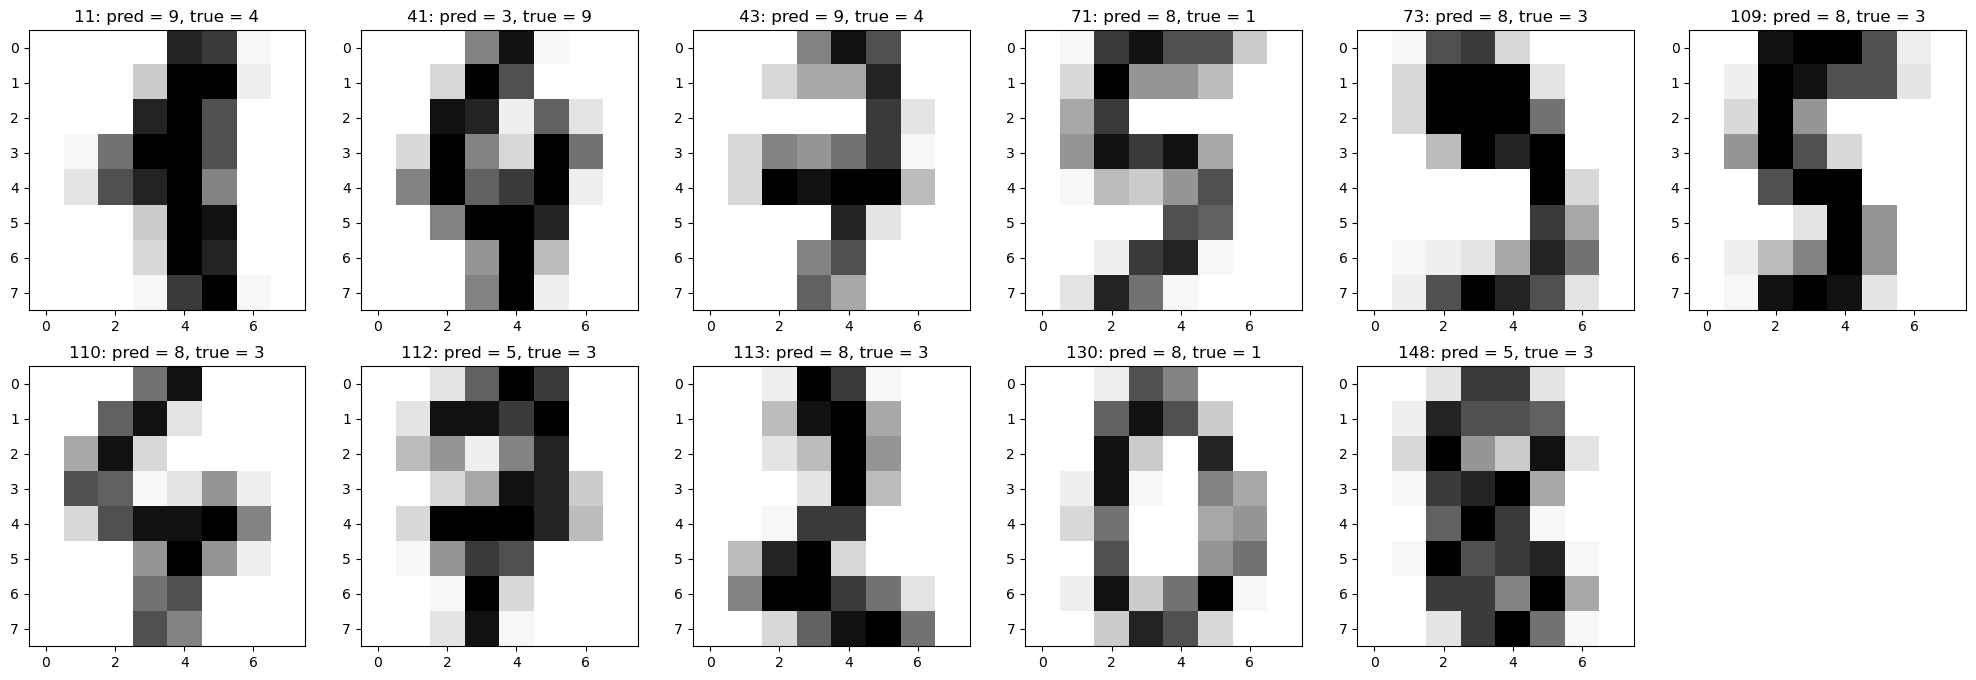

In [14]:
# visualize the incorrect predictions
plt.figure(figsize = (25, 8))
for i in range(11):
    plt.subplot(2, 6, i+1)
    plt.imshow(X_digits[incorrect[i]].reshape(8, 8), cmap = 'Greys', aspect = 'auto', interpolation = 'None')
    plt.title(f"{incorrect[i]}: pred = {pred[incorrect[i]]}, true = {y_test[incorrect[i]]}")

ii) In a 10-fold x-validation on this full dataset, what are the mean test and training scores, and from a confusion matrix determine which digit on average is most often misidentified with which other digit.

In [16]:
from sklearn.model_selection import cross_validate

In [17]:
# perform a cross-validation across 10 folds and calculate the mean train and test scores
scores = cross_validate(logreg_ovr, X_digits, y_digits, cv = 10, scoring = 'accuracy', return_train_score = True)

print(f"train score: {np.mean(scores['train_score'])}")
print(f"test_score: {np.mean(scores['test_score'])}")

train score: 0.9974648607616998
test_score: 0.928767846058349


In [18]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

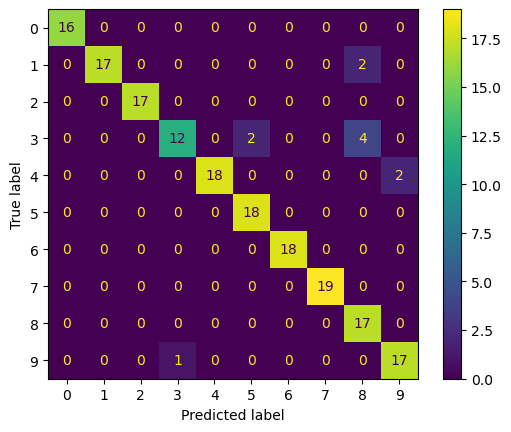

In [19]:
# create a confusion matrix
y_pred = logreg_ovr.predict(X_test)
ConfusionMatrixDisplay.from_estimator(logreg_ovr, X_test, y_test);

In [20]:
cm = confusion_matrix(y_test, y_pred)
# remove the diagonals from cm so that only the misclassifications remain
cm = cm - np.diag(np.diag(cm))     
# index of the max value in cm (most misclassifications)
misidentified_index = np.argmax(cm)     
# uses misidentified_index and returns the row and col from cm to get the actual digits
most_misidentified = np.unravel_index(misidentified_index, cm.shape) 
# prints the actual digits that get confused
print(f"digit {most_misidentified[0]} is most often confused as {most_misidentified[1]}")

digit 3 is most often confused as 8


### 1.B

In [22]:
test3 = [X_test[i].copy() for i in [11, 43, 113]]
logreg_ovr.predict(test3)
# should be 4, 4, 3

array([9, 9, 8])

Recall that `logreg_ovr.predict(test3)` will give the predictions for each of the three, `y_test[[11, 43, 113]]` will give their labelled values, and `logreg_ovr.predict_proba(test3)` will give the ten probabilities that they're each of the ten digits. (The `.predict()` method picks the label with the highest probability, as discussed in class.)

One way to manipulate an image to be classified instead as its actual label would be to look at the associated weights. `logref_ovr.coef_` is an array of shape `(10,64)`, and each row is an array of 64 weights that multiply the corresponding pixel values. (These weights are called $\vec w_i$ in the [lec10_slides.pdf](https://courses.cit.cornell.edu/info3950_2025sp/lec10_slides.pdf) notes.) `logref_ovr.intercept_` is an array of `10` numbers that provide the thresholds for each of the 10 "one versus rest" classifiers (0 or not 0, 1 or not 1, ...), and are added in turn to the corresponding sum of products of weights and features for each digit. (These are called $b_i$ in the formula $x_i = \vec w_i \cdot \vec f + \vec b_i$ in the lec10 slides.)

Suppose an image should be classified as 3. `logreg_ovr.coef_[3]` gives the 64 weights used in the "3 or not 3" classifier.  Identify the largest weight and see if the corresponding pixel in the image is already large (the max value is 16). If it is not already large, then see what happens when you increase its value. Otherwise look for the most negative weight, see if that corresponding pixel has a large value, and check what happens if you decrease it. Either way should make it more likely for the image to be classified as a 3.

If this doesn't work suppose an image is misclassified as 8, the look instead at `logreg_ovr.coef_[8]`, and to make that *less* likely either decrease the value of a pixel that has a large positive weight, or increase the value of a pixel that has a large negative weight. Again remember that pixel values are integers only in the range 0,1,2,...,15,16 ). In all cases you should use the smallest change in the pixel value to produce the desired effect -- a 'minimal' manipulation.

i) Find (at least one) minimal single pixel manipulation of each of the three images that corrects the predictions. Visualize the images, indicating the location of the altered pixel in each. [See note added below]

In [25]:
# test3[0]
logreg_ovr.coef_[4].argmax()

41

The pixel at index 41 has the highest weight for determining whether an image is 4 or not

In [27]:
test3[0][41]

0.0

The pixel at index 41 has a very small value (out of 16.0). Therefore, I will increase it to make it more likely for the image to be classified as a 4.

In [29]:
test3[0][41] = 16.0
logreg_ovr.predict([test3[0]])

array([4])

I changed the pixel value to the highest possible value (16.0) and the classification of the number changed from 9 to 4.

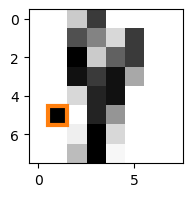

In [31]:
plt.figure(figsize = (2,2))
plt.imshow(np.reshape(test3[0], (8, 8)), cmap = 'Greys', aspect = 1, interpolation = 'none')
row, col = divmod(41, 8)
plt.gca().add_patch(plt.Rectangle((col - 0.5, row - 0.5), 1, 1, color = 'none', ec = 'C1', linewidth = 3))

In [32]:
# test3[1]
logreg_ovr.coef_[4].argmax()

41

The pixel at index 41 has the highest weight for determining whether an image is 4 or not

In [34]:
test3[1][41]

0.0

The pixel at index 41 has a very small value (out of 16.0). Therefore, I will increase it to make it more likely for the image to be classified as a 4.

In [36]:
test3[1][41] = 16.0
logreg_ovr.predict([test3[0]])

array([4])

I changed the pixel value to the highest possible value (16.0) and the classification of the number changed from 9 to 4.

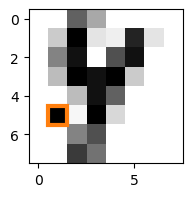

In [38]:
plt.figure(figsize = (2,2))
plt.imshow(np.reshape(test3[1], (8, 8)), cmap = 'Greys', aspect = 1, interpolation = 'none')
row, col = divmod(41, 8)
plt.gca().add_patch(plt.Rectangle((col - 0.5, row - 0.5), 1, 1, color = 'none', ec = 'C1', linewidth = 3))

In [39]:
# test3[2]
logreg_ovr.coef_[3].argmax()

58

The pixel at index 58 has the highest weight for determining whether an image is 3 or not

In [41]:
test3[2][58]

10.0

The pixel at index 58 has a value that is moderate. I will both increase and decrease the pixel value to see how it affects our classification.

In [43]:
test3[2][58] = 0.0
logreg_ovr.predict([test3[2]])

array([8])

In [44]:
test3[2][58] = 16.0
logreg_ovr.predict([test3[2]])

array([3])

Increasing the pixel value to 16.0 leads to the correct classification of 3 while decreasing it leads to an incorrect classification of 8. 

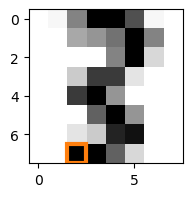

In [46]:
plt.figure(figsize = (2,2))
plt.imshow(np.reshape(test3[2], (8, 8)), cmap = 'Greys', aspect = 1, interpolation = 'none')
row, col = divmod(58, 8)
plt.gca().add_patch(plt.Rectangle((col - 0.5, row - 0.5), 1, 1, color = 'none', ec = 'C1', linewidth = 3))

ii) [Bonus] Find all minimal single pixel manipulations that correct the predictions of the three images.

In [48]:
test3 = [X_test[i].copy() for i in [11, 43, 113]]
pred_labels = logreg_ovr.predict(test3)
true_labels = [y_test[i] for i in [11, 43, 113]]
print(f"predicted labels: {pred_labels}, true labels: {true_labels}")

predicted labels: [9 9 8], true labels: [4, 4, 3]


In [49]:
image_indices = [11, 43, 113]

In [1]:
for i, image in enumerate(test3):
    if pred_labels[i] != true_labels[i]:
        og_index = image_indices[i]
        print(f"image {og_index} is incorrect --> original prediction: {pred_labels[i]}, true label: {true_labels[i]}")

        for row in range(8):
            for col in range(8):
                original_pixel_value = image[row * 8 + col]

                if original_pixel_value <= 8:
                    new_pixel_value = 16.0
                else:
                    new_pixel_value = 0.0

                image[row * 8 + col] = new_pixel_value

                new_pred_label = logreg_ovr.predict([image])[0]
                
                if new_pred_label == true_labels[i]:
                    print(f"image {og_index} corrected by changing pixel ({row}, {col}) from {original_pixel_value} to {new_pixel_value}" \
                          f" with new prediction {new_pred_label}")
        

NameError: name 'test3' is not defined

### 1.C

Now check how the probabilities are calculated. `logreg_ovr.predict_proba([X_test[43]])` gives the probabilities that the first test image is each of the ten digits (as indicated above, the highest does not give correctly the labelled value `y_test[43]` for this image).  Which three digits does the classifier assign the highest probabilities for this image?

Use `logreg_ovr.coef_` and `logreg_ovr.intercept_` to calculate the values $x_i = \vec w_i \cdot \vec f + \vec b_i$ (where the 64 $\vec f$ values are given by `X_test[110]`), then plug them into the (binomial) logistic function $q(i) = 1/(1+\exp(-x_i))$. Finally, calculate the probabilities $p(i) = q(i) / \sum_{j=0}^9 q(j)$. These should agree with the values given by `logreg_ovr.predict_proba([X_test[43]])`.

In [53]:
logreg_ovr.predict_proba([X_test[43]])

array([[5.09511341e-11, 2.68210392e-10, 3.92969505e-08, 8.93828171e-18,
        2.68573396e-01, 1.01782665e-06, 1.78229156e-09, 7.45144606e-08,
        3.58371493e-01, 3.73053977e-01]])

4, 8, and 9 have the highest probabilities, as shown in the printed array above

In [55]:
x = logreg_ovr.coef_ @ X_test[43] + logreg_ovr.intercept_
q = 1 / (1 + np.exp(-x))
p = q / q.sum()
p

array([5.09511341e-11, 2.68210392e-10, 3.92969505e-08, 8.93828171e-18,
       2.68573396e-01, 1.01782665e-06, 1.78229156e-09, 7.45144606e-08,
       3.58371493e-01, 3.73053977e-01])

### 1.D
(i) `logreg_ovr.predict_proba()` gives for the one-pixel image at left probabilities roughly equal to 1/2 (within 1%) for two digits. What is the value of the pixel (a positive integer $\le 16$), and what are the two digits?

In [57]:
max_prob1 = 0
max_prob2 = 0
digits = (None, None)
best_value = -1

for index in range(64):
    for value in range(1, 17):
        x = np.zeros((1, 64))
        x[0, index] = value
        
        prob = logreg_ovr.predict_proba(x)
        indices = np.argsort(prob[0])[-2:]

        prob1 = prob[0][indices[0]]
        prob2 = prob[0][indices[1]]

        if prob1 + prob2 > max_prob1 + max_prob2:
            max_prob1 = prob1
            max_prob2 = prob2
            best_value = value
            digits = (indices[0], indices[1])
            
print(f"pixel value: {best_value}, probabilities: {max_prob1}, {max_prob2}, digits: {digits[0]}, {digits[1]}")

pixel value: 16, probabilities: 0.43641636708435805, 0.46462077924298356, digits: 5, 0


(ii) `logreg_ovr.predict_proba()` gives for the two-pixel image at right probabilities roughly equal to 1/3 (within 2%) for three digits. What are the values of the pixels (positive integers $\le 16$), and what are the three digits?

In [59]:
max_prob1 = 0
max_prob2 = 0
max_prob3 = 0 
digits = (None, None, None)
best_value = -1

for index in range(64):
    for value in range(1, 17):
        x = np.zeros((1, 64))  
        x[0, index] = value    

        prob = logreg_ovr.predict_proba(x)

        indices = np.argsort(prob[0])[-3:]

        prob1 = prob[0][indices[0]]
        prob2 = prob[0][indices[1]]
        prob3 = prob[0][indices[2]]

        if prob1 + prob2 + prob3 > max_prob1 + max_prob2 + max_prob3:
            max_prob1 = prob1
            max_prob2 = prob2
            max_prob3 = prob3
            best_value = value
            digits = (indices[0], indices[1], indices[2])

print(f"pixel value: {best_value}, probabilities: {max_prob1}, {max_prob2}, {max_prob3}, digit: {digits[0]}, {digits[1]}, {digits[2]}")

pixel value: 16, probabilities: 0.21803257913838794, 0.3840177777764588, 0.39059833880861056, digit: 4, 2, 3


### 1.E
Now train a classifier using the 'multinomial' option, 

    logreg_multi = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg')
    
use it to fit the same training data as above, and score on the same test data. You should find again 169/180, but check whether it misses a different set of 11 images. (In fact, although it misses overall the same number, the ones that it misses are slightly different.)  In particular see whether it misses the three `test3 = X_test[[1, 43, 113]]` in part **B**, and see whether the single pixel manipulations used in parts **B.i,ii,iii** correctly alter the result of this classifier as well.

In [61]:
# load data
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

In [62]:
# split into train and test 90/10
n_samples = len(X_digits)
f = int(0.9 * n_samples)

X_train = X_digits[:f] #first 90%
y_train = y_digits[:f]

X_test = X_digits[f:]  #last 10%
y_test = y_digits[f:]

In [63]:
logreg_multi = linear_model.LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg').fit(X_train, y_train)
print('LogisticRegression test score (multi): {:.6f}'.format(logreg_multi.score(X_test, y_test)))

LogisticRegression test score (multi): 0.933333


In [64]:
# print the indices of the X_test array corresponding to the ones our model got wrong
incorrect = []
pred = logreg_multi.predict(X_test)

for i in range(y_test.size):
    if y_test[i] != pred[i]:
        incorrect.append(i)
        print(i)

11
41
43
63
73
106
109
110
112
113
130
148


In [65]:
test3 = X_test[[11, 43, 113]]
test3_pred = logreg_multi.predict(test3)
print(f"test3 predictions: {test3_pred}")
print(f"actual predictions: {y_test[[11, 43, 113]]}")

test3 predictions: [9 9 8]
actual predictions: [4 4 3]


In [66]:
# test3[0]
logreg_multi.coef_[4].argmax()

41

In [67]:
test3[0][41]

0.0

In [68]:
test3[0][41] = 16.0
logreg_multi.predict([test3[0]])

array([4])

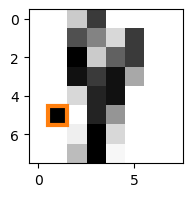

In [69]:
plt.figure(figsize = (2,2))
plt.imshow(np.reshape(test3[0], (8, 8)), cmap = 'Greys', aspect = 1, interpolation = 'none')
row, col = divmod(41, 8)
plt.gca().add_patch(plt.Rectangle((col - 0.5, row - 0.5), 1, 1, color = 'none', ec = 'C1', linewidth = 3))

In [70]:
# test3[1]
logreg_multi.coef_[4].argmax()

41

In [71]:
test3[1][41]

0.0

In [72]:
test3[1][41] = 16.0
logreg_multi.predict([test3[0]])

array([4])

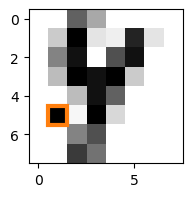

In [73]:
plt.figure(figsize = (2,2))
plt.imshow(np.reshape(test3[1], (8, 8)), cmap = 'Greys', aspect = 1, interpolation = 'none')
row, col = divmod(41, 8)
plt.gca().add_patch(plt.Rectangle((col - 0.5, row - 0.5), 1, 1, color = 'none', ec = 'C1', linewidth = 3))

In [74]:
# test3[2]
logreg_multi.coef_[3].argmax()

4

In [75]:
test3[2][58]

10.0

In [76]:
test3[2][58] = 16.0
logreg_multi.predict([test3[2]])

array([3])

In [77]:
test3[2][58] = 0.0
logreg_multi.predict([test3[2]])

array([8])

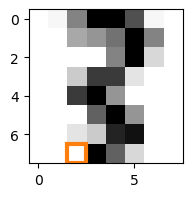

In [78]:
plt.figure(figsize = (2,2))
plt.imshow(np.reshape(test3[2], (8, 8)), cmap = 'Greys', aspect = 1, interpolation = 'none')
row, col = divmod(58, 8)
plt.gca().add_patch(plt.Rectangle((col - 0.5, row - 0.5), 1, 1, color = 'none', ec = 'C1', linewidth = 3))

The `logreg_multi` classifies some of the pixels differently. For the single pixel manipulations, the first two of the single pixels were classified the same as `logreg_ovr` and classified the same when the pixel values were changed. However, for the third pixel, `logreg_multi` only classified 3 to 8 correctly when the pixel value was decreased whereas it correctly predicted for `logreg_ovr` when the pixel value was increased.

### 1.F
Now see how the `logreg_multi.predict_proba()` probabilities are calculated. Using the `.coef_` and `.intercept_` attributes, calculate the $x_i = \vec w_i \cdot \vec f + \vec b_i$, as in part **C** for $\vec f$ features given by `X_test[43]`. Now calculate the probabilities using the multinomial logistic formula $p(i) = \exp(x_i) / \sum_{i=0}^9 \exp(x_i)$.
These should agree with the values given by `logreg_multi.predict_proba([X_test[43]])`.

In [81]:
logreg_multi.predict_proba([X_test[43]])

array([[2.40564552e-12, 1.26394200e-08, 6.85281263e-09, 1.14065068e-11,
        1.86226304e-03, 2.93357905e-08, 1.97931131e-09, 2.58396130e-07,
        4.66668924e-02, 9.51470535e-01]])

In [82]:
x = logreg_multi.coef_ @ X_test[43] + logreg_multi.intercept_
p = np.exp(x) / np.sum(np.exp(x))
p

array([2.40564552e-12, 1.26394200e-08, 6.85281263e-09, 1.14065068e-11,
       1.86226304e-03, 2.93357905e-08, 1.97931131e-09, 2.58396130e-07,
       4.66668924e-02, 9.51470535e-01])

### 1.G
So far, this problem has only considered a single train/test data split. Produce another plot along the lines of 1B above to see whether either `multi_class='ovr'` or the default `multi_class='multinomial'` can improve the 10-fold cross-validated average test score for some value of regularization `C`.

In [84]:
from sklearn.model_selection import cross_val_score

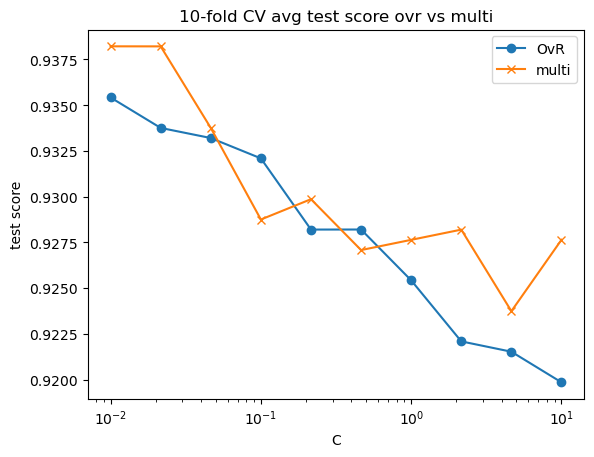

In [85]:
C_values = np.logspace(-2, 1, 10)
ovr_scores = []
multi_scores = []

for C in C_values:
    logreg_ovr = linear_model.LogisticRegression(multi_class = 'ovr', solver = 'newton-cg', C = C)
    logreg_multi = linear_model.LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', C = C)
    
    ovr_cv = np.mean(cross_val_score(logreg_ovr, X_digits, y_digits, scoring = 'accuracy', cv = 10))
    multi_cv = np.mean(cross_val_score(logreg_multi, X_digits, y_digits, scoring = 'accuracy', cv = 10))

    ovr_scores.append(ovr_cv)
    multi_scores.append(multi_cv)

plt.plot(C_values, ovr_scores, marker = 'o', label = 'OvR')
plt.plot(C_values, multi_scores, marker = 'x', label = 'multi')
plt.title('10-fold CV avg test score ovr vs multi')
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('test score')
plt.legend()
plt.show()

## 2.  Logistic regression for text classification

### 2.A
i) Return to problem 1 of [ps2](https://nbviewer.jupyter.org/url/courses.cit.cornell.edu/info3950_2025sp/ps2.ipynb),
and use instead logistic regression for the binary features on the same feature sets in part 1A (1000 most common), and 1B (1000 most discriminating, that appear in at least 10 of the 2000 texts) -- it may need `max_iter=1000`, and leave the regularization at the default `C=1` (and similarly for the rest of ps4, unless specified otherwise).
Use `cross_val_score()` to see whether the mean score for 10-fold cross validation improves over the Bernoulli naive Bayes in ps2#1A.

This should be very simple, since the feature sets are the same as before, it's just a question of swapping in [sklearn.linear_model.LogisticRegression()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) instead of 
[sklearn.naive_bayes.BernoulliNB()](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) (and you have access to ps2 solutions). 

In [88]:
#setup for inline plotting
import matplotlib.pyplot as plt, numpy as np
%matplotlib inline
from collections import Counter
import re

In [89]:
from glob import glob #gets list of files from directory

negfiles = sorted(glob('review_polarity/txt_sentoken/neg/*.txt'))
posfiles = sorted(glob('review_polarity/txt_sentoken/pos/*.txt'))

negtexts = [open(f).read() for f in negfiles]
postexts = [open(f).read() for f in posfiles]

len(negtexts), len(postexts)

(1000, 1000)

In [90]:
def words(txt): return re.findall(r"['\w]+", txt.lower())

In [91]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

In [92]:
nvocab = Counter()
for txt in negtexts:
    for w in set(words(txt)): nvocab[w] += 1
        
pvocab = Counter()
for txt in postexts:
    for w in set(words(txt)): pvocab[w] += 1

allwords = pvocab + nvocab
allwords.most_common(10)

[('the', 1999),
 ('and', 1998),
 ('of', 1998),
 ('to', 1997),
 ('a', 1996),
 ('is', 1995),
 ('in', 1994),
 ('that', 1957),
 ('with', 1944),
 ('it', 1935)]

In [93]:
Nf=1000
vocab = sorted (allwords, key=allwords.get, reverse=True)[:Nf]  #Nf most common
word_index = {w:k for k,w in enumerate(vocab)} #assigns word each an index by rank
set_vocab = set(vocab)

def features(txt,Nf):
    f = np.zeros(Nf)
    for w in set(words(txt)) & set_vocab: f[word_index[w]] = 1
    return f  #array of zeros and ones for whether or not feature words occur

In [94]:
X_data = [features(txt,Nf) for txt in negtexts+postexts]
y_data = [0]*1000 + [1]*1000

In [95]:
clf = LogisticRegression(max_iter = 1000, C = 1)

scores = cross_val_score(clf, X_data, y_data, cv = 10)
scores, scores.mean()

(array([0.77 , 0.79 , 0.815, 0.78 , 0.765, 0.815, 0.82 , 0.8  , 0.77 ,
        0.835]),
 0.796)

In [96]:
disc10 = {w: (nvocab[w]+.5)/(pvocab[w]+.5) for w in allwords if allwords[w]>=10}

In [97]:
Nf=1000
vocab = sorted (disc10, key=disc10.get, reverse=True)[:Nf//2] +\
         sorted (disc10, key=disc10.get)[:Nf//2]
word_index = {w:k for k,w in enumerate(vocab)} #assigns word each an index by rank
set_vocab = set(vocab)

In [98]:
X_data2 = [features(txt,Nf) for txt in negtexts+postexts]
y_data2 = [0]*1000 + [1]*1000

scores2 = cross_val_score(clf, X_data2, y_data2, cv=10) # or try cv = 20 for 95%/5% splits
scores2, scores2.mean()

(array([0.9  , 0.895, 0.895, 0.875, 0.865, 0.905, 0.92 , 0.875, 0.875,
        0.915]),
 0.8919999999999998)

In [99]:
print(f"ps2 1A score: ~{0.7935000000000001:.3f}, ps4 score: ~{scores.mean():.3f}")
print(f"ps2 1B score: ~{0.909:.3f}, ps4 score: ~{scores2.mean():.3f}")

ps2 1A score: ~0.794, ps4 score: ~0.796
ps2 1B score: ~0.909, ps4 score: ~0.892


Using logistic regression, the mean scores improved for ps2 1A but not for ps2 1B

ii) In lec 12 (Tue 3 Mar), we discussed the role of "regularization" and how it works. In the case of most common features above, you should find that with the default regularization `C=1` there's a very slight improvement in average test score over `BernoulliNB()`, but the training score is 100%, the usual signal of overfitting. Increase the regularization, by decreasing `C`, to see if you can bring the average test score up by a few percent (into the low 80s).

In [102]:
clf_reg = LogisticRegression(max_iter = 1000, C = 0.5)
reg_score = cross_val_score(clf_reg, X_data, y_data, cv = 10)
print(reg_score, reg_score.mean())

[0.77  0.805 0.81  0.785 0.77  0.81  0.84  0.8   0.77  0.845] 0.8005000000000001


In [103]:
clf_reg = LogisticRegression(max_iter = 1000, C = 0.05)
reg_score = cross_val_score(clf_reg, X_data, y_data, cv = 10)
print(reg_score, reg_score.mean())

[0.8   0.8   0.81  0.805 0.795 0.85  0.835 0.835 0.785 0.86 ] 0.8175000000000001


In [104]:
clf_reg = LogisticRegression(max_iter = 1000, C = 0.005)
reg_score = cross_val_score(clf_reg, X_data, y_data, cv = 10)
print(reg_score, reg_score.mean())

[0.82  0.805 0.78  0.8   0.82  0.835 0.855 0.83  0.82  0.855] 0.8220000000000001


In [105]:
clf_reg = LogisticRegression(max_iter = 1000, C = 0.0005)
reg_score = cross_val_score(clf_reg, X_data, y_data, cv = 10)
print(reg_score, reg_score.mean())

[0.78  0.765 0.76  0.76  0.795 0.78  0.815 0.81  0.79  0.82 ] 0.7875000000000001


As C = 0.005, the average test score increases into the low 80s. However, if C is decreased too much, the average test score actually decreases.

### 2.B
Note: Here the features are termed 'numerical' (vs. (0,1) boolean), rather than 'multinomial', to distinguish that from the entirely different notion of 'multinomial' used in logistic regression (which in turn will later be called 'softmax', as discussed in class).

i) Problem 2 of [ps2](https://nbviewer.jupyter.org/url/courses.cit.cornell.edu/info3950_2025sp/ps2.ipynb)
used `BernoulliNB()` to classify the twelve sets of abstracts in `ps1data`. Try using `LogisticRegression()` on both the binary and 'multinomial' features for this 12-class data, and see whether the mean 10-fold cross validation improves. (This is again just an exercise in swapping in a different classifier function, and you can try both `multi_class='ovr'` or the default `multi_class='multinomial'` for this.)

In [108]:
import re, matplotlib.pyplot as plt, numpy as np
%matplotlib inline
from collections import Counter, defaultdict
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold

In [109]:
from ps1data import absdata
classnames = sorted(absdata)
print (classnames)

['astro-ph.IM', 'cond-mat.mes-hall', 'cs.CV', 'cs.HC', 'cs.LG', 'hep-ph', 'hep-th', 'math.AP', 'physics.app-ph', 'physics.comp-ph', 'q-bio.NC', 'quant-ph']


In [110]:
def words(txt): return re.findall(r"['\w]+", txt.lower())

In [111]:
vocab = {subj: Counter() for subj in classnames}
for subj in classnames:
  for txt in absdata[subj]:
     for w in set(words(txt)): vocab[subj][w] += 1
            
#make a combined total_vocab
total_vocab = Counter()
for subj in classnames: total_vocab += vocab[subj]
len(total_vocab)

38238

In [112]:
Nf = 2500
nstop = 29
Nfvocab, Nfn = zip(*total_vocab.most_common(Nf+nstop)[nstop:])
word_index = {w:k for k,w in enumerate(Nfvocab)} #assigns each word an index by rank
set_vocab = set(Nfvocab)

In [113]:
def features(txt, Nf):
    f = np.zeros(Nf)
    for w in set(words(txt)) & set_vocab: f[word_index[w]] = 1
    return f  #array of zeros and ones for whether or not feature words occur

def num_features(txt, Nf):
    f = np.zeros(Nf)
    for w in words(txt):
        if w in set_vocab:
            f[word_index[w]] += 1
    return f

In [114]:
X_binary = np.array([features(txt, Nf) for subj in classnames for txt in absdata[subj]]) #all data
y_data = np.array([[i]*1000 for i in range(12)]).flatten() #all data

X_numerical = np.array([num_features(txt, Nf) for subj in classnames for txt in absdata[subj]])

In [115]:
clf = LogisticRegression(max_iter = 1000, multi_class = 'multinomial')

In [116]:
binary_scores = cross_val_score(clf, X_binary, y_data, cv = 10)
print(f"binary scores: {binary_scores.mean()}")

numerical_scores = cross_val_score(clf, X_numerical, y_data, cv = 10)
print(f"numerical scores: {numerical_scores.mean()}")

binary scores: 0.8295833333333332
numerical scores: 0.8227499999999999


ii) In Lecture 12, there was a blackboard sketch of the effect of changing regularization `C` on the training and test scores for this problem, to suggest how an optimal value of `C` can be chosen. (The sketch was along the lines of the below, but note that the numbers below are not supposed to be accurate.)  Reproduce the graph for this problem, comparing average test and training scores for 10-fold validation for boolean and numerical features over a range of `C` (the plot below uses `np.logspace(-4,1,16)`, and you can use the default `multi_class='multinomial'` for this, or again try both) 

In [119]:
from scipy.sparse import csr_matrix
X_binary = csr_matrix(X_binary)
X_numerical = csr_matrix(X_numerical)

iteration 1: processing C = 0.0001
iteration 2: processing C = 0.00021544346900318845
iteration 3: processing C = 0.00046415888336127773
iteration 4: processing C = 0.001
iteration 5: processing C = 0.002154434690031882
iteration 6: processing C = 0.004641588833612777
iteration 7: processing C = 0.01
iteration 8: processing C = 0.021544346900318822
iteration 9: processing C = 0.046415888336127774
iteration 10: processing C = 0.1
iteration 11: processing C = 0.21544346900318823
iteration 12: processing C = 0.46415888336127775
iteration 13: processing C = 1.0
iteration 14: processing C = 2.154434690031882
iteration 15: processing C = 4.641588833612772
iteration 16: processing C = 10.0


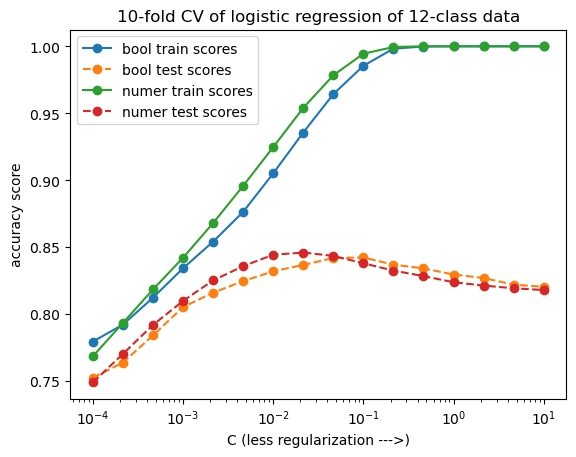

In [120]:
C_values = np.logspace(-4, 1, 16)
bool_train_scores = []
bool_test_scores = []
num_train_scores = []
num_test_scores = []
i = 0

for C in C_values:
    i += 1
    print(f"iteration {i}: processing C = {C}")
    
    clf = LogisticRegression(max_iter = 1000, multi_class = 'multinomial', C = C, solver = 'saga')
    
    bool = cross_validate(clf, X_binary, y_data, cv = 10, n_jobs = -1, return_train_score = True)
    numerical = cross_validate(clf, X_numerical, y_data, cv = 10, n_jobs = -1, return_train_score = True)
    
    bool_train_scores.append(bool['train_score'].mean())
    bool_test_scores.append(bool['test_score'].mean())
    num_train_scores.append(numerical['train_score'].mean())
    num_test_scores.append(numerical['test_score'].mean())
    
plt.plot(C_values, bool_train_scores, marker = 'o', linestyle = '-', label = 'bool train scores')
plt.plot(C_values, bool_test_scores, marker = 'o', linestyle = '--', label = 'bool test scores')
plt.plot(C_values, num_train_scores, marker = 'o', linestyle = '-', label = 'numer train scores')
plt.plot(C_values, num_test_scores, marker = 'o', linestyle = '--', label = 'numer test scores')
plt.title('10-fold CV of logistic regression of 12-class data')
plt.xlabel('C (less regularization --->)')
plt.xscale('log')
plt.ylabel('accuracy score')
plt.legend()
plt.show()

### 2.C
In problem 3B of [ps2](https://nbviewer.org/url/courses.cit.cornell.edu/info3950_2025sp/ps2.ipynb), you trained Naive Bayes classifiers on the full text data in 
[ps2data.py.gz](https://courses.cit.cornell.edu/info3950_2025sp/ps2data.py.gz), as a function of the number of features.  Compare the results of that problem to "multinomial" logistic regression, using the numeric (i.e., non-boolean (0/1)) features.

Your plot should be formatted as below (note however that while the NB data is actual, i.e., direct from 
[s2.ipynb](https://nbviewer.org/url/courses.cit.cornell.edu/info3950_2025sp/s2.ipynb), the logistic data (green)
is entirely synthetic data, not necessarily expected to resemble your real data in any qualitative or quantitative way):

In [122]:
from ps2data import txtdata
classnames = sorted(txtdata)

In [123]:
def nfeatures(txt,Nf):
    f = np.zeros(Nf)
    count = Counter(words(txt))
    for w in set(count) & set_vocab: f[word_index[w]] = count[w]
    return f  #array of number of times each feature occurs in txt

In [124]:
vocab = {subj: Counter() for subj in classnames}
for subj in classnames:
  for txt in txtdata[subj]:
     for w in set(words(txt)): vocab[subj][w] += 1

total_vocab = Counter()
for subj in classnames: total_vocab += vocab[subj]

Nf = 263287 -212
nstop = 212
Nfvocab, Nfn = zip(*total_vocab.most_common(Nf+nstop)[nstop:])
word_index = {w:k for k,w in enumerate(Nfvocab)} #assigns each word an index by rank
set_vocab = set(Nfvocab)

X_data = np.array([nfeatures(txt,Nf) for subj in classnames for txt in txtdata[subj]]) #all data
y_data = np.array([[i]*500 for i in range(4)]).flatten() #all data
print(X_data.shape, y_data.shape)


(2000, 263075) (2000,)


In [125]:
clf = MultinomialNB()  #now defaults to alpha = 1
scores = cross_val_score(clf, X_data, y_data, cv=10) # or try cv = 20 for 95%/5% splits
print ('mean = {:.1%}'.format(round(scores.mean(),3)))

mean = 84.6%


In [126]:
#multinomial
meanscores = []
for Nf in 2**np.arange(12):
    set_vocab = set(Nfvocab[:Nf])
    #scores = cross_val_score(clf, X_data[:,:Nf], y_data, cv=5)
    output = cross_validate(clf, X_data[:,:Nf], y_data, return_train_score=True, cv=10)
    print (Nf, f"means: train={output['train_score'].mean():.1%}, test={output['test_score'].mean():.1%}")
    meanscores.append((output['train_score'].mean(),output['test_score'].mean()))

meanscores = np.array(meanscores).T

1 means: train=25.0%, test=25.0%
2 means: train=37.0%, test=37.0%
4 means: train=39.7%, test=38.8%
8 means: train=43.5%, test=43.1%
16 means: train=54.0%, test=52.8%
32 means: train=66.2%, test=65.2%
64 means: train=72.6%, test=71.9%
128 means: train=75.3%, test=74.2%
256 means: train=78.4%, test=77.3%
512 means: train=80.8%, test=79.3%
1024 means: train=81.9%, test=79.8%
2048 means: train=83.6%, test=81.5%


In [127]:
clfB = BernoulliNB()
X_dataB = np.array([features(txt,Nf) for subj in classnames for txt in txtdata[subj]]) #all data

In [128]:
#bernoulli
meanscoresB = []
for Nf in 2**np.arange(12):
    set_vocab = set(Nfvocab[:Nf])
    #scores = cross_val_score(clfB, X_dataB[:,:Nf], y_data, cv=10)
    output = cross_validate(clfB, X_dataB[:,:Nf], y_data, return_train_score=True, cv=10)
    print (Nf, f"means: train={output['train_score'].mean():.1%}, test={output['test_score'].mean():.1%}")
    meanscoresB.append((output['train_score'].mean(),output['test_score'].mean()))

meanscoresB=np.array(meanscoresB).T

1 means: train=36.4%, test=36.4%
2 means: train=40.5%, test=39.8%
4 means: train=42.9%, test=42.9%
8 means: train=45.8%, test=45.1%
16 means: train=52.9%, test=51.6%
32 means: train=61.3%, test=59.0%
64 means: train=66.1%, test=63.8%
128 means: train=70.4%, test=68.1%
256 means: train=73.8%, test=71.9%
512 means: train=77.2%, test=75.2%
1024 means: train=79.1%, test=77.0%
2048 means: train=81.5%, test=79.4%


In [129]:
clfLR = LogisticRegression(max_iter = 10000)
X_dataLR = np.array([nfeatures(txt, Nf) for subj in classnames for txt in txtdata[subj]])

In [130]:
# "multinomial" logistic regression
meanscoresLR = []
for Nf in 2**np.arange(12):
    set_vocab = set(Nfvocab[:Nf])
    #scores = cross_val_score(clfB, X_dataB[:,:Nf], y_data, cv=10)
    output = cross_validate(clfLR, X_dataLR[:,:Nf], y_data, return_train_score=True, cv=10)
    print (Nf, f"means: train={output['train_score'].mean():.1%}, test={output['test_score'].mean():.1%}")
    meanscoresLR.append((output['train_score'].mean(),output['test_score'].mean()))

meanscoresLR=np.array(meanscoresLR).T

1 means: train=35.4%, test=35.4%
2 means: train=40.7%, test=40.2%
4 means: train=43.3%, test=42.5%
8 means: train=44.9%, test=44.0%
16 means: train=56.4%, test=53.5%
32 means: train=70.5%, test=66.8%
64 means: train=78.1%, test=73.0%
128 means: train=85.1%, test=73.6%
256 means: train=99.4%, test=68.8%
512 means: train=100.0%, test=73.8%
1024 means: train=100.0%, test=77.5%
2048 means: train=100.0%, test=80.1%


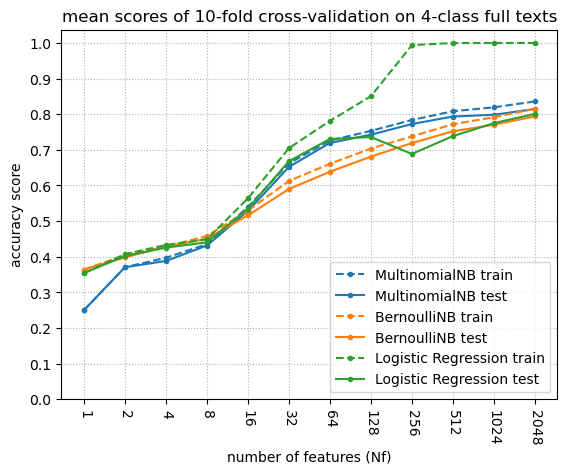

In [131]:
plt.title('mean scores of 10-fold cross-validation on 4-class full texts')
plt.plot(meanscores[0][:12], 'C0.--', label='MultinomialNB train')
plt.plot(meanscores[1][:12], '.-', label='MultinomialNB test')
plt.plot(meanscoresB[0][:12], 'C1.--', label='BernoulliNB train')
plt.plot(meanscoresB[1][:12], '.-', label='BernoulliNB test')
plt.plot(meanscoresLR[0][:12], 'C2.--', label = 'Logistic Regression train')
plt.plot(meanscoresLR[1][:12], '.-', label = 'Logistic Regression test')
plt.xticks(range(12), 2**np.arange(12), rotation=270)
plt.yticks(np.arange(0,1.01,.1))
plt.grid(ls=':')
plt.xlabel('number of features (Nf)')
plt.ylabel('accuracy score')
plt.legend()
plt.show()